# **COMPSCIX433.6-012 Final Project**
# Team: Dark Arts<br>
Mandy Chiang<br>
Theodore Jagodits<br>
Ernest Obrock


In [169]:
# import required libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import decomposition

# Set global Seaborn params
sns.set_style("whitegrid")
sns.set(font_scale=1.2)

# **Intro/Problem Statement:**
## For our project, we would like to predict user churn, using user demographic and other account/service information from a telecommunications company. Churn is one of many SaaS metrics, which are extremely important and relevant today. To be able to predict churn of customers would be extremely valuable to SaaS companies.  

In [170]:
# read data from github
Customer_data = pd.read_csv('https://raw.githubusercontent.com/treselle-systems/customer_churn_analysis/master/WA_Fn-UseC_-Telco-Customer-Churn.csv', delimiter=',')

In [171]:
# inspect head / get a look at data
Customer_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# **Column/Attribute Descriptions: (Most of these are self explanatory)**

---
<pre>
customerID        unique ID number for each customer
gender            Male/Female
SeniorCitizen     Yes/No (1/0)  
Partner           Does the customer have a spouse/partner (Yes/No) 
Dependents        Does the customer have dependents (Yes/No) 
tenure            Time in Months of customer tenure  
PhoneService      Yes/No
MultipleLines     More than 1 phone line (Yes/No/No Service) 
InternetService   DSL/Fiber/No 
OnlineSecurity    Yes/No/No Internet Service
OnlineBackup      Yes/No/No Internet Service
DeviceProtection  Yes/No/No Internet Service
TechSupport       Yes/No/No Internet Service
StreamingTV       Yes/No/No Internet Service 
StreamingMovies   Yes/No/No Internet Service 
Contract          Month-to-Month/1 year/2 year 
PaperlessBilling  Yes/No
PaymentMethod     Elec Check/Mailed Check/ACH/CC 
MonthlyCharges    $ amount of monthly bill
TotalCharges      $ amount of total charges to date 
Churn             Did customer drop service (Yes/No) 
</pre>

In [172]:
# Ignoring customerID, there are quite a bit of Binary and Categorical (nominal) variables.
# And there are 3 continuous variabes: tenure, MonthlyCharges and TotalCharges
Customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [173]:
# Check the distribution of the variables
Customer_data[['tenure','MonthlyCharges','TotalCharges']].describe()

,tenure,MonthlyCharges
count,7043.000000,7043.000000
mean,32.371149,64.761692
std,24.559481,30.090047
min,0.000000,18.250000
25%,9.000000,35.500000
50%,29.000000,70.350000
75%,55.000000,89.850000
max,72.000000,118.750000


In [174]:
# There are no missing values for all columns
print(Customer_data.isnull().sum())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


## Great Success. Dataframe looks good. 7,043 records. No Nulls, yay! Now we need to look at distribution of each attribute (column). Curious that TotalCharges is an object, let's change it to a float.  

In [175]:
# Returns Error, need to investigate further (see below)
#Customer_data.TotalCharges = Customer_data.TotalCharges.astype(float)

## Looks like there are some records in the TotalCharges column, that contain strings. Will need to resolve, before converting to float. 

In [176]:
# Object types can actually contain different class types (not all string), ie str, int, float. 
# Let's check the column TotalCharges
Customer_data['TotalCharges'].apply(type).value_counts()

<class 'str'>    7043
Name: TotalCharges, dtype: int64

## Ok, so that doesn't tell us much (they are all class type str). Multiple ways to drill down now. Best to get used to doing this in Python, versus looking at data in CSV; getting used to working with "Big Data". Data sets with 100,000 plus records/rows becomes very tedious to work with in Excel (excel will/can freeze). 

In [177]:
# Have to assume there are some spaces between delimiters in CSV. Pretty "clean" way to examine: 
Customer_data[['customerID','Contract','MonthlyCharges','TotalCharges','Churn']][(Customer_data.TotalCharges.str.isspace() == True)]

,customerID,Contract,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Two year,52.55,,No
753,3115-CZMZD,Two year,20.25,,No
936,5709-LVOEQ,Two year,80.85,,No
1082,4367-NUYAO,Two year,25.75,,No
1340,1371-DWPAZ,Two year,56.05,,No
3331,7644-OMVMY,Two year,19.85,,No
3826,3213-VVOLG,Two year,25.35,,No
4380,2520-SGTTA,Two year,20.00,,No
5218,2923-ARZLG,One year,19.70,,No
6670,4075-WKNIU,Two year,73.35,,No


In [178]:
# Another way to check
Customer_data.TotalCharges[(Customer_data.TotalCharges==" ")].count()

11

## Ok we got lucky. It appears that the reason TotalCharges is an object, is that we have 11 records with no value; empty string (" "). So let's replace those 11 values with zero.

In [179]:
Customer_data.TotalCharges.replace({" ":0}, inplace=True)

In [180]:
# Now we can convert to float for use in analysis and graphs/plots
Customer_data.TotalCharges = Customer_data.TotalCharges.astype(float)

In [181]:
Customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [182]:
print(Customer_data[['customerID','MonthlyCharges','TotalCharges']][(Customer_data.MonthlyCharges==0)|(Customer_data.TotalCharges==0)])

      customerID  MonthlyCharges  TotalCharges
488   4472-LVYGI           52.55           0.0
753   3115-CZMZD           20.25           0.0
936   5709-LVOEQ           80.85           0.0
1082  4367-NUYAO           25.75           0.0
1340  1371-DWPAZ           56.05           0.0
3331  7644-OMVMY           19.85           0.0
3826  3213-VVOLG           25.35           0.0
4380  2520-SGTTA           20.00           0.0
5218  2923-ARZLG           19.70           0.0
6670  4075-WKNIU           73.35           0.0
6754  2775-SEFEE           61.90           0.0


In [183]:
# What to do about 11 records with "missing" value for TotalCharges?
# We could make assumption that these are brand new customers
# Most conservative would be to remove 11 records
Customer_data.drop(Customer_data[(Customer_data.TotalCharges==0)].index, inplace=True, axis=0)

In [184]:
Customer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


In [185]:
# Now we can check the distribution of the variables
Customer_data[['tenure','MonthlyCharges','TotalCharges']].describe()

,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


Distribution of Churn


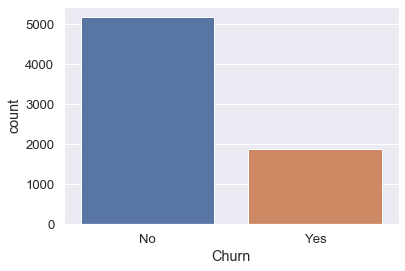

In [186]:
sns.countplot(x="Churn", data=Customer_data)
print('Distribution of Churn')

In [187]:
print('Percentage of customers that Churn: {:.2%}'.format(Customer_data['Churn'][(Customer_data.Churn == "Yes")].count() / Customer_data.Churn.count()))

Percentage of customers that Churn: 26.58%


## Quite a bit of customers that are loyal. But a churn of 26% of customers is troubling. 

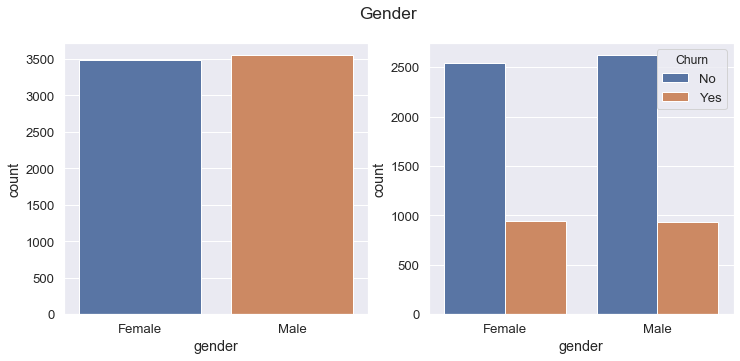

In [188]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.countplot(x="gender", data=Customer_data, ax=ax[0])
sns.countplot(x="gender", hue="Churn",data=Customer_data, ax=ax[1])
plt.suptitle('Gender');

## Pretty equal distribution of Female and Male customers. Churn amongst gender is the same. 

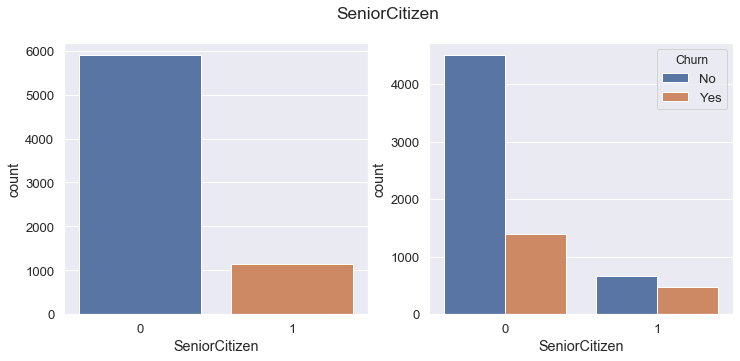

In [189]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.countplot(x="SeniorCitizen", data=Customer_data, ax=ax[0])
sns.countplot(x="SeniorCitizen", hue="Churn",data=Customer_data, ax=ax[1])
plt.suptitle('SeniorCitizen');

In [190]:
print('Percent senior citizen {:.2%}'.format(Customer_data['SeniorCitizen'][(Customer_data.SeniorCitizen==1)].count()/Customer_data.SeniorCitizen.count()))

Percent senior citizen 16.24%


## ~16% of customers are senior citizens; small percentage of total. More customers that are not senior citizens, tend to churn. 

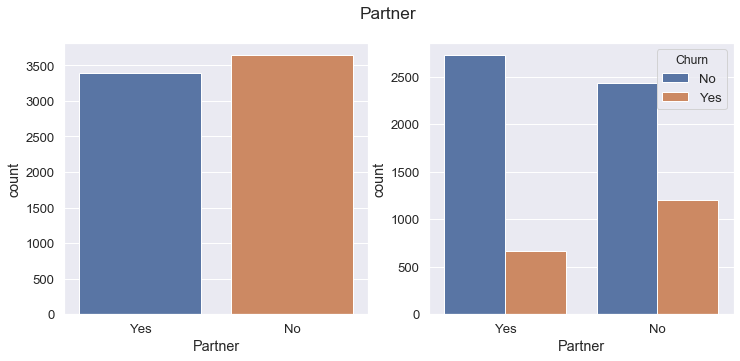

In [191]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.countplot(x="Partner", data=Customer_data, ax=ax[0])
sns.countplot(x="Partner", hue="Churn",data=Customer_data, ax=ax[1])
plt.suptitle('Partner');

## Again, as with gender, pretty equal distribution of whether or not the customer has a partner. More customers with no partner, churn. 

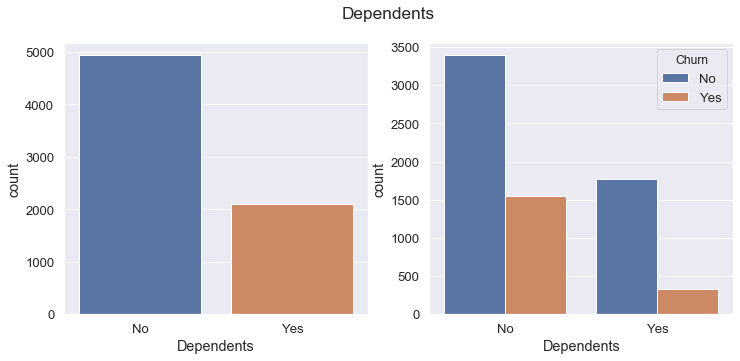

In [192]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.countplot(x="Dependents", data=Customer_data, ax=ax[0])
sns.countplot(x="Dependents", hue="Churn",data=Customer_data, ax=ax[1])
plt.suptitle('Dependents');

In [193]:
print('Percent with dependents: {:.2%}'.format(Customer_data['Dependents'][(Customer_data.Dependents=='Yes')].count()/Customer_data.Dependents.count()))

Percent with dependents: 29.85%


## ~30% of customers have dependents, so 70% of customers are singles; good to know for future targeted marketing. More customers without dependents churn. 

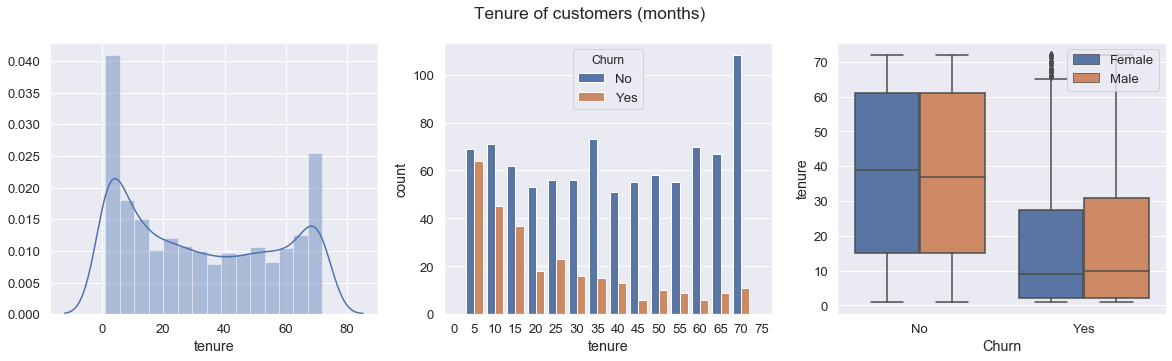

In [194]:
fig, ax = plt.subplots(1,3, figsize=(20,5))
sns.distplot(Customer_data.tenure, ax=ax[0])
sns.countplot(x="tenure", hue="Churn",data=Customer_data, ax=ax[1],order=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75])
sns.boxplot(x="Churn", y="tenure", hue="gender", data=Customer_data, ax=ax[2])
ax[2].legend(loc='upper right')
plt.suptitle('Tenure of customers (months)');

## Tenure is skewed to left and right. Customers lean to either being with the company for very little time, or with the company for a long time (in months). As for churn, pretty good correlation; The less tenure a customer has, the more likely they are to churn.  

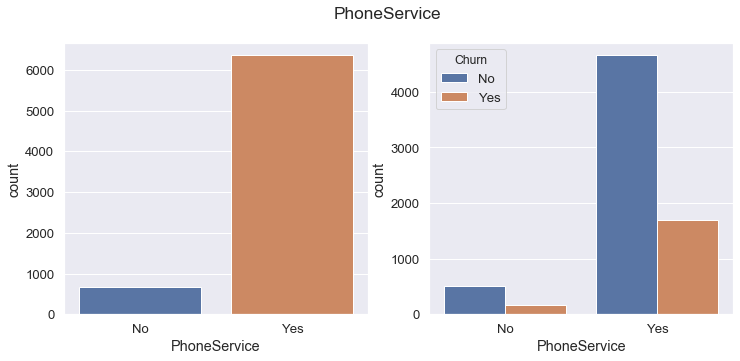

In [195]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.countplot(x="PhoneService", data=Customer_data, ax=ax[0])
sns.countplot(x="PhoneService", hue="Churn",data=Customer_data, ax=ax[1])
plt.suptitle('PhoneService');

In [196]:
print('Percent with phone service: {:.2%}'.format(Customer_data['PhoneService'][(Customer_data.PhoneService=='Yes')].count()/Customer_data.PhoneService.count()))

Percent with phone service: 90.33%


## wow, overwhelming majority of customers have phone service included with their package. Hard to analyze churn, since majority of customers have phone service. 

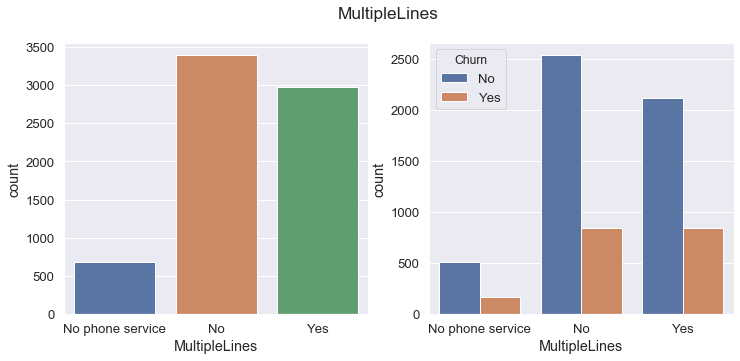

In [197]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.countplot(x="MultipleLines", data=Customer_data, ax=ax[0])
sns.countplot(x="MultipleLines", hue="Churn",data=Customer_data, ax=ax[1])
plt.suptitle('MultipleLines');

## For the majority of customers that that have phone service, pretty equal distribution of single line vs. multiple lines. 

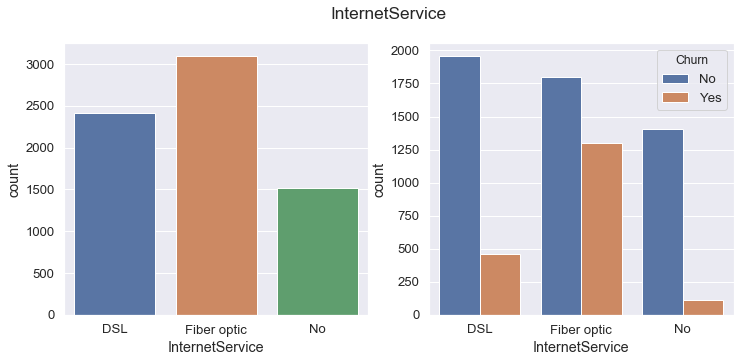

In [198]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.countplot(x="InternetService", data=Customer_data, ax=ax[0])
sns.countplot(x="InternetService", hue="Churn",data=Customer_data, ax=ax[1])
plt.suptitle('InternetService');

In [199]:
print('Number without internet service: {:,}'.format(Customer_data['InternetService'][(Customer_data.InternetService=='No')].count()))

Number without internet service: 1,520


## Surprising how many people actually don't have internet service. More customers with Fiber optic than DSL. 

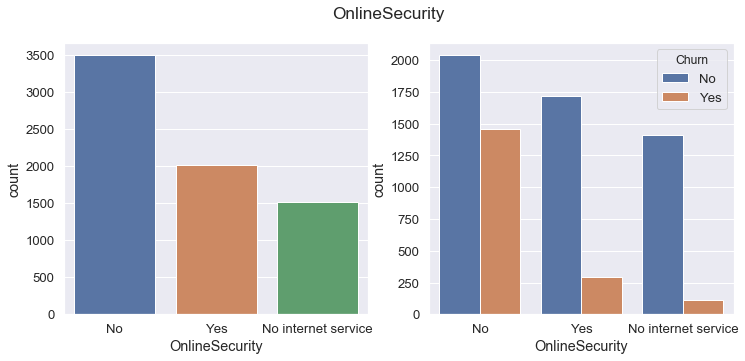

In [200]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.countplot(x="OnlineSecurity", data=Customer_data, ax=ax[0])
sns.countplot(x="OnlineSecurity", hue="Churn",data=Customer_data, ax=ax[1])
plt.suptitle('OnlineSecurity');

In [201]:
print('Percent without OnlineSecurity: {:.2%}'.format(Customer_data['OnlineSecurity'][(Customer_data.OnlineSecurity=='No')].count()/Customer_data['OnlineSecurity'][(Customer_data.OnlineSecurity!="No internet service")].count()))

Percent without OnlineSecurity: 63.44%


## Besides the 1,526 customers who do not have internet service, ~63% of customers do not have OnlineSecurity. 

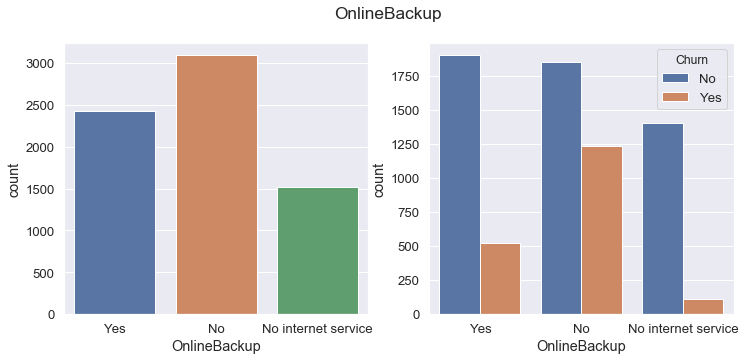

In [202]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.countplot(x="OnlineBackup", data=Customer_data, ax=ax[0])
sns.countplot(x="OnlineBackup", hue="Churn",data=Customer_data, ax=ax[1])
plt.suptitle('OnlineBackup');

## Of those that have internet, more customers do not have online backup as a service. 

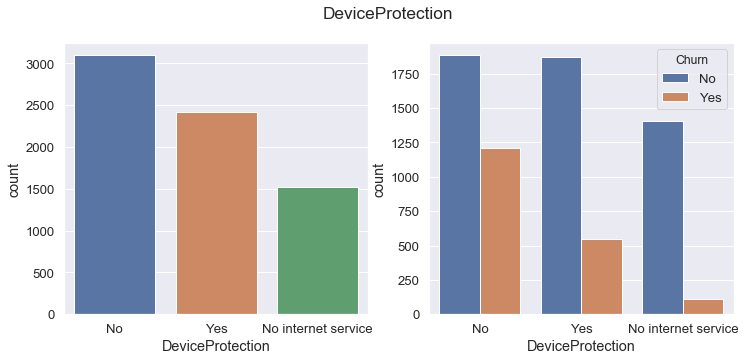

In [203]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.countplot(x="DeviceProtection", data=Customer_data, ax=ax[0])
sns.countplot(x="DeviceProtection", hue="Churn",data=Customer_data, ax=ax[1])
plt.suptitle('DeviceProtection');

## Starting to see a trend here with optional (premium?) service options. A lot of customers do not have internet device protection. The same can be said for online security and online backup. Let's see if that is the case for Tech Support. 

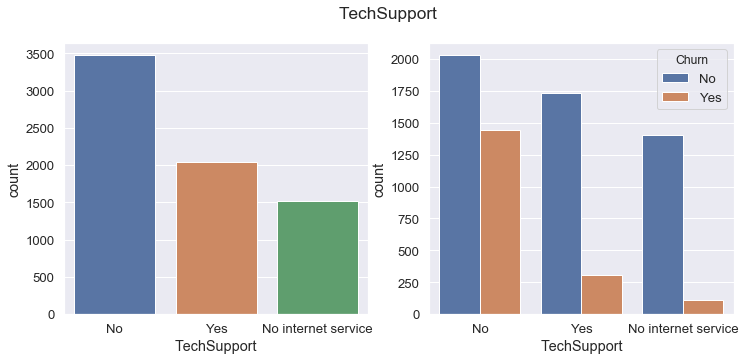

In [204]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.countplot(x="TechSupport", data=Customer_data, ax=ax[0])
sns.countplot(x="TechSupport", hue="Churn",data=Customer_data, ax=ax[1])
plt.suptitle('TechSupport');

## Just as we assumed. Many customers do not pay for internet technical support. As we have seen with all of these optional or "premium" services, churn is higher among customers that do not pay for these extra services.  

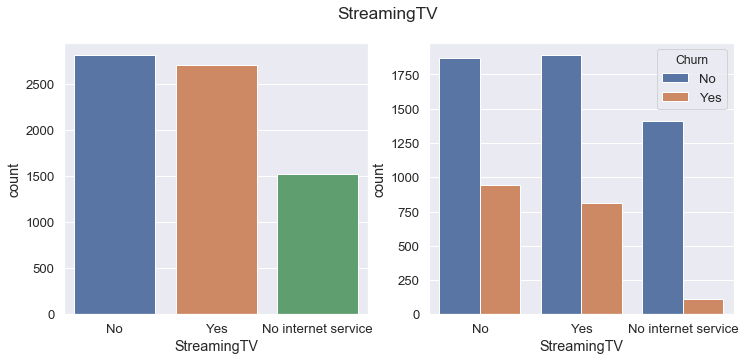

In [205]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.countplot(x="StreamingTV", data=Customer_data, ax=ax[0])
sns.countplot(x="StreamingTV", hue="Churn",data=Customer_data, ax=ax[1])
plt.suptitle('StreamingTV');

In [206]:
print('Number with streaming TV: {:,}'.format(Customer_data['StreamingTV'][(Customer_data.StreamingTV=='Yes')].count()))
print('Percentage of Total Pop. : {:.2%}'.format(Customer_data['StreamingTV'][(Customer_data.StreamingTV=='Yes')].count()/ Customer_data['StreamingTV'].count()))

Number with streaming TV: 2,703
Percentage of Total Pop. : 38.44%


## Of the 5,517 customers who have internet service only 2,707 pay for streaming TV. Does this tell us something about the geographical location or demographics of these customers?   

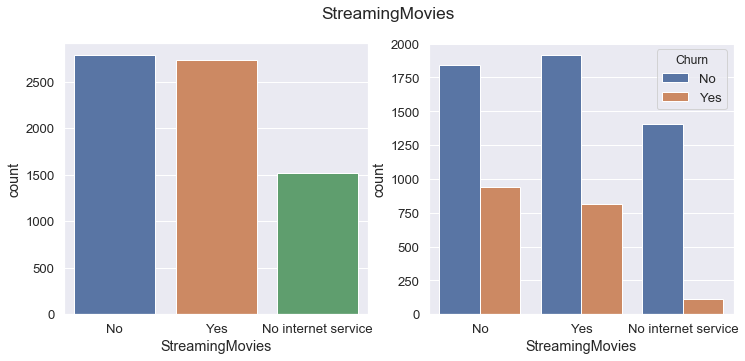

In [207]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.countplot(x="StreamingMovies", data=Customer_data, ax=ax[0])
sns.countplot(x="StreamingMovies", hue="Churn",data=Customer_data, ax=ax[1])
plt.suptitle('StreamingMovies');

## Here again with Streaming Movies, pretty 50/50 of customers who stream vs. those that do not. No overwhelming trend towards streaming it appears. 

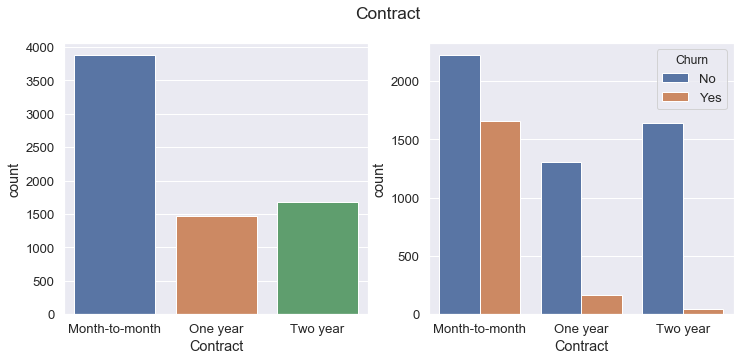

In [208]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.countplot(x="Contract", data=Customer_data, ax=ax[0])
sns.countplot(x="Contract", hue="Churn",data=Customer_data, ax=ax[1])
plt.suptitle('Contract');

## Majority of customers are on month-to-month contracts, their churn numbers are also the highest. 

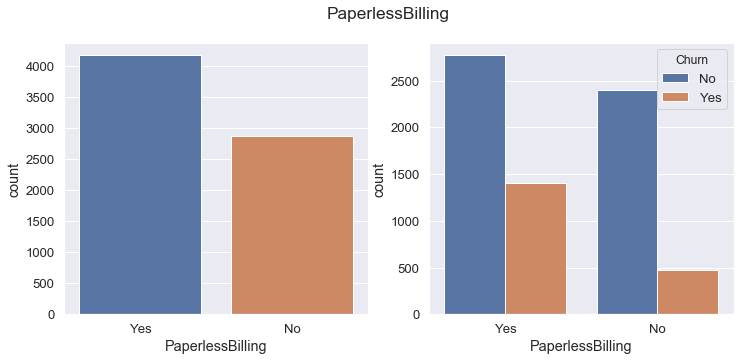

In [209]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.countplot(x="PaperlessBilling", data=Customer_data, ax=ax[0])
sns.countplot(x="PaperlessBilling", hue="Churn",data=Customer_data, ax=ax[1])
plt.suptitle('PaperlessBilling');

## More customers tend to have paperless billing as part of their service. 

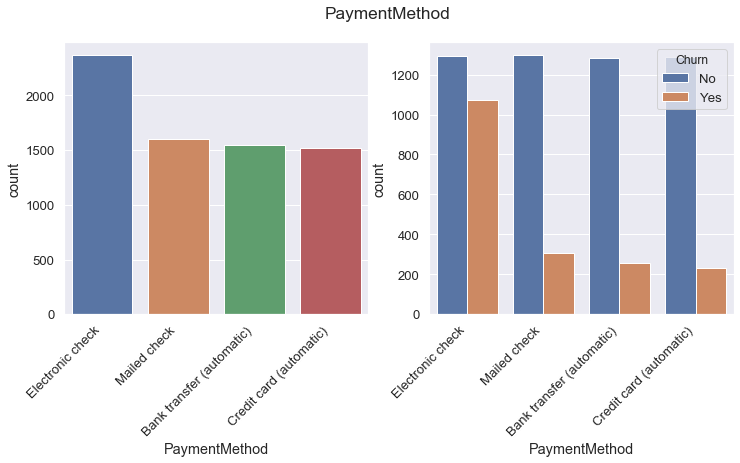

In [210]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
fig1 = sns.countplot(x="PaymentMethod", data=Customer_data, ax=ax[0])
fig2 = sns.countplot(x="PaymentMethod", hue="Churn",data=Customer_data, ax=ax[1])
fig1.set_xticklabels(fig1.get_xticklabels(), rotation=45, horizontalalignment='right')
fig2.set_xticklabels(fig2.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.suptitle('PaymentMethod');

## Much more churn with payment method as electronic check. 

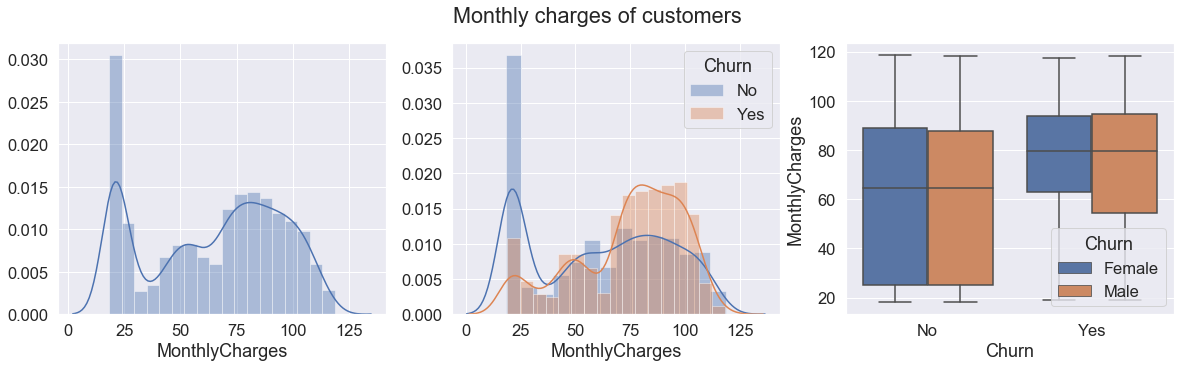

In [211]:
sns.set_style("whitegrid")
sns.set(font_scale=1.5)
fig, ax = plt.subplots(1,3, figsize=(20,5))
sns.distplot(Customer_data.MonthlyCharges, ax=ax[0])
sns.distplot(Customer_data['MonthlyCharges'][(Customer_data.Churn == "No")],label="No",ax=ax[1])
sns.distplot(Customer_data['MonthlyCharges'][(Customer_data.Churn == "Yes")],label="Yes",ax=ax[1])
sns.boxplot(x="Churn", y="MonthlyCharges", hue="gender", data=Customer_data, ax=ax[2]);
ax[1].legend(loc='best',title='Churn')
ax[2].legend(loc='lower right',title='Churn')
plt.suptitle("Monthly charges of customers");

In [212]:
Customer_data['MonthlyCharges'][(Customer_data.MonthlyCharges < 25.55)].count()

1521

In [213]:
Customer_data.MonthlyCharges.describe()

count    7032.000000
mean       64.798208
std        30.085974
min        18.250000
25%        35.587500
50%        70.350000
75%        89.862500
max       118.750000
Name: MonthlyCharges, dtype: float64

## There are a lot of customers that do not have internet service (1,526), and therefore would not have extra services (costs) associated with internet. Also, it appears to make sense that as we move to the higher tail end of monthly charges, there would be a higher chance of churn, because of the financial burden of those high monthly charges. 

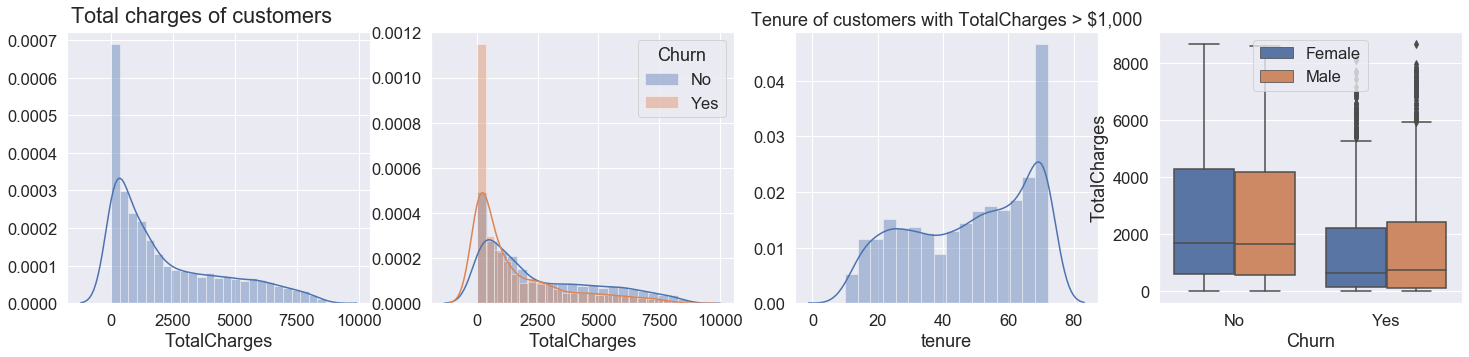

In [214]:
sns.set(font_scale=1.5)
fig, ax = plt.subplots(1,4, figsize=(25,5))
sns.distplot(Customer_data.TotalCharges, ax=ax[0])
sns.distplot(Customer_data['TotalCharges'][(Customer_data.Churn == "No")],label="No",ax=ax[1])
sns.distplot(Customer_data['TotalCharges'][(Customer_data.Churn == "Yes")],label="Yes",ax=ax[1])
ax[1].legend(title="Churn")
sns.distplot(Customer_data['tenure'][(Customer_data.TotalCharges>1000)],ax=ax[2])
ax[2].set_title("Tenure of customers with TotalCharges > $1,000")
sns.boxplot(x="Churn", y="TotalCharges", hue="gender", data=Customer_data, ax=ax[3])
ax[3].legend(loc='upper center')
plt.suptitle("Total charges of customers", x=0.2, y=.95);

## Appears to be more churn towards the lower end of TotalCharges. Overall, the pattern seems to be if you have a family (partner and/or dependents), you have higher tenure, you use some of the "premium" services (online backup, tech support, device protection, online security), and your monthly charges are not too high, you're less likely to stop being a customer. As shown with TotalCharges per customer, those with higher TotalCharges (>$1,000) have been with the company for some time. 

In [215]:
# Really no need for Customer ID, as they are unique values, not helpful predictors of Y (churn)
Customer_data.drop(labels='customerID', axis=1, inplace=True)

## Prep the data for use in predictive models

In [216]:
'''
Label encoding the dataset. 
This is because we are using classifier(s) 
and not linear regression to solve this problem (dummy variables).

We need to adjust gender, partner, dependents, phoneservice, 
multiple lines (3 options), internetservice (3 options), onlinesecurity(3), 
online backup(3), device protection(3), tech support(3), streamingtv(3)
streamingMovies(3), contract(3), paperless(2), paymentmethod(4), churn(2)
'''

# get all categorical columns that needs to be transformed
label_transform = Customer_data.drop(columns=['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'tenure']).copy(deep=True)

# label encode the data
label_enc = LabelEncoder()
label_transform_enc = (label_transform.apply(label_enc.fit_transform))

# merge numerical columns onto transformed dataframe
all_label_data = pd.merge(Customer_data[['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'tenure']],label_transform_enc,how="left",left_index=True,right_index=True)

# reorder the dataframe to original order
Columns = list(Customer_data.columns.values)
all_label_data = all_label_data[Columns]

In [217]:
# check for success
all_label_data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


In [218]:
# double check data
all_label_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   int64  
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   int64  
 3   Dependents        7032 non-null   int64  
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   int64  
 6   MultipleLines     7032 non-null   int64  
 7   InternetService   7032 non-null   int64  
 8   OnlineSecurity    7032 non-null   int64  
 9   OnlineBackup      7032 non-null   int64  
 10  DeviceProtection  7032 non-null   int64  
 11  TechSupport       7032 non-null   int64  
 12  StreamingTV       7032 non-null   int64  
 13  StreamingMovies   7032 non-null   int64  
 14  Contract          7032 non-null   int64  
 15  PaperlessBilling  7032 non-null   int64  
 16  PaymentMethod     7032 non-null   int64  


In [219]:
# get X and y
X = all_label_data.drop(labels='Churn', axis=1)
Y = all_label_data['Churn']
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=.8, random_state=6)

In [220]:
# Create dataframe to store model metrics to compare later
df = {'Name': [],\
      'Fit (Train)':[],\
      'Fit (Test)' :[],\
      'Accuracy':[],\
      'F1-Score':[],\
      'MSE':[], \
      'Feature Importance':[]}
Model_summary = pd.DataFrame(df)
Columns = pd.DataFrame(X.columns)

## Run various models and compare

In [221]:
# XG Boost
xgBoost = GradientBoostingClassifier()
xgBoost.fit(x_train,y_train)
xgBoost_pred = xgBoost.predict(x_test)
xgBoost_feature_importance = permutation_importance(xgBoost, x_train, y_train, n_repeats=10, scoring='accuracy').importances_mean
#add metrics to model summary
new_row =  pd.DataFrame({\
        'Name':'XG Boost', \
        'Fit (Train)': [xgBoost.score(x_train, y_train)],\
        'Fit (Test)': [xgBoost.score(x_test,y_test)], \
        'Accuracy': [accuracy_score(y_test, xgBoost_pred)], \
        'F1-Score': [f1_score(y_test, xgBoost_pred)], \
        'MSE': [mean_squared_error(y_test, xgBoost_pred)], \
        'Feature Importance': [xgBoost_feature_importance]})
Model_summary = Model_summary.append(new_row, ignore_index=True)

In [222]:
# Logistic Regression
logistic = LogisticRegression(max_iter=500)
logistic.fit(x_train,y_train)
logistic_pred = logistic.predict(x_test)
logistic_feature_importance = permutation_importance(logistic, x_train, y_train, n_repeats=10, scoring='accuracy').importances_mean
#add metrics to model summary
new_row =  pd.DataFrame({\
        'Name':'Logistic Regression', \
        'Fit (Train)': [logistic.score(x_train, y_train)],\
        'Fit (Test)': [logistic.score(x_test,y_test)], \
        'Accuracy': [accuracy_score(y_test, logistic_pred)], \
        'F1-Score': [f1_score(y_test, logistic_pred)], \
        'MSE': [mean_squared_error(y_test, logistic_pred)],\
        'Feature Importance': [logistic_feature_importance]})
Model_summary = Model_summary.append(new_row, ignore_index=True)

In [223]:
# debugging
# pd.DataFrame({'Actual': np.array(y_test).flatten(), 'Predicted': np.array(xgBoost_pred).flatten()})

In [224]:
# SVM Classifier 
# Speed up by scaling data through pipeline
# Takes 2 min, 30 sec to run
svc = make_pipeline(StandardScaler(), SVC(kernel='rbf', cache_size=1000))
svc.fit(x_train,y_train)
svc_pred = svc.predict(x_test)
svc_feature_importance = permutation_importance(svc, x_train, y_train, n_repeats=10, scoring='accuracy').importances_mean
#add metrics to model summary
new_row =  pd.DataFrame({\
        'Name':'SVM Classifier', \
        'Fit (Train)': [svc.score(x_train, y_train)],\
        'Fit (Test)': [svc.score(x_test,y_test)], \
        'Accuracy': [accuracy_score(y_test, svc_pred)], \
        'F1-Score': [f1_score(y_test, svc_pred)],\
        'MSE': [mean_squared_error(y_test, svc_pred)],\
        'Feature Importance': [svc_feature_importance]})
Model_summary = Model_summary.append(new_row, ignore_index=True)

In [225]:
# Decision Tree
# Created a pipline to optimize parameters
# Just learning how to do a pipeline; this needs further study
'''
tree_pipe = Pipeline(steps=[('pca',decomposition.PCA()),('decisiontree',DecisionTreeClassifier())])

n_components = list(range(1,X.shape[1]+1,1))
criterion = ['gini', 'entropy']
max_depth = [4,6,8,12];

parameters = dict(pca__n_components=n_components,\
                  decisiontree__criterion=criterion,\
                  decisiontree__max_depth=max_depth)

decision_tree = GridSearchCV(tree_pipe, parameters)
'''
decision_tree = DecisionTreeClassifier()
decision_tree.fit(x_train,y_train)
decision_tree_pred = decision_tree.predict(x_test)
dt_feature_importance = permutation_importance(decision_tree, x_train, y_train, n_repeats=10, scoring='accuracy').importances_mean
#add metrics to model summary
new_row =  pd.DataFrame({\
        'Name':'Decision Tree Classifier', \
        'Fit (Train)': [decision_tree.score(x_train, y_train)],\
        'Fit (Test)': [decision_tree.score(x_test,y_test)], \
        'Accuracy': [accuracy_score(y_test, decision_tree_pred)], \
        'F1-Score': [f1_score(y_test, decision_tree_pred)],\
        'MSE': [mean_squared_error(y_test, decision_tree_pred)],\
        'Feature Importance': [dt_feature_importance]})
Model_summary = Model_summary.append(new_row, ignore_index=True)

## Plot summary of models and evaluate performance

In [226]:
Model_summary.head()

,Name,Fit (Train),Fit (Test),Accuracy,F1-Score,MSE,Feature Importance
0,XG Boost,0.827556,0.813077,0.813077,0.603318,0.186923,"[0.0007288888888889123, 0.004622222222222261, ..."
1,Logistic Regression,0.801956,0.815920,0.815920,0.635724,0.184080,"[0.0019555555555555103, 0.0004977777777777414,..."
2,SVM Classifier,0.818844,0.802416,0.802416,0.572308,0.197584,"[0.005333333333333379, 0.007040000000000046, 0..."
3,Decision Tree Classifier,0.998400,0.733475,0.733475,0.514877,0.266525,"[0.02024888888888885, 0.031644444444444385, 0...."


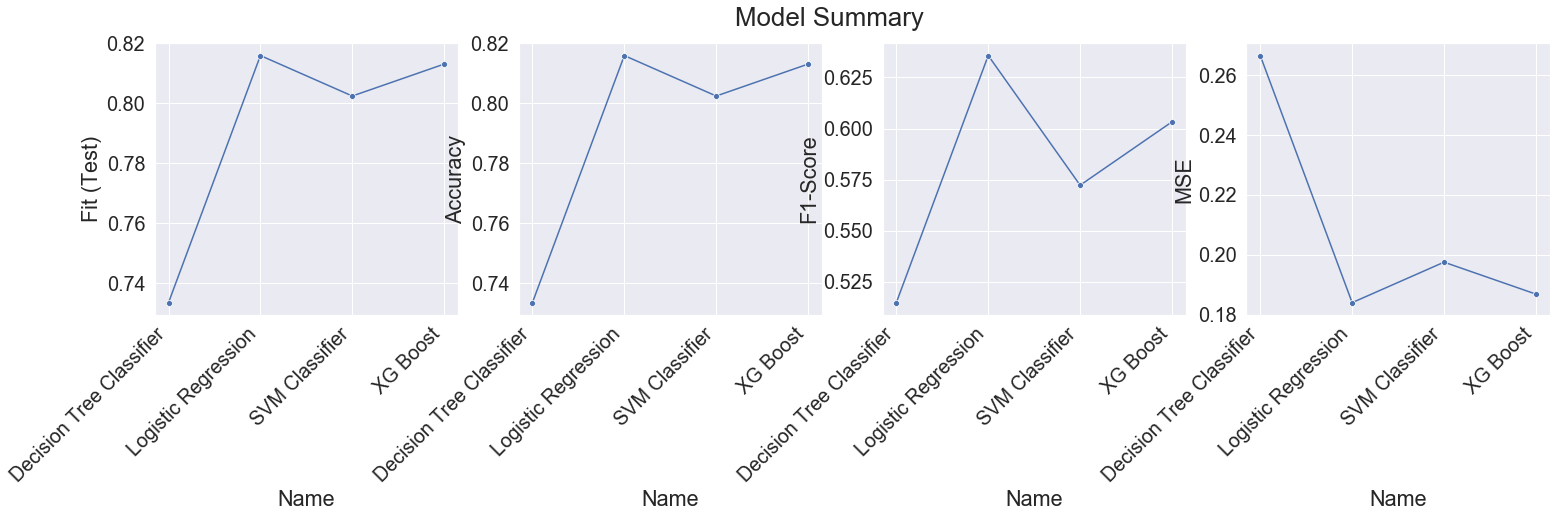

In [227]:
# plot Model Summary
sns.set(font_scale=1.8)
fig, ax = plt.subplots(1,4, figsize=(25,5))

sns.lineplot(x="Name", y="Fit (Test)", marker='o',data=Model_summary, ax=ax[0])
sns.lineplot(x="Name", y="Accuracy", marker='o',data=Model_summary, ax=ax[1])
sns.lineplot(x="Name", y="F1-Score", marker='o',data=Model_summary, ax=ax[2])
sns.lineplot(x="Name", y="MSE", marker='o', data=Model_summary, ax=ax[3])

plt.setp(ax[0].get_xticklabels(), rotation=45, ha='right') 
plt.setp(ax[1].get_xticklabels(), rotation=45, ha='right') 
plt.setp(ax[2].get_xticklabels(), rotation=45, ha='right') 
plt.setp(ax[3].get_xticklabels(), rotation=45, ha='right') 

plt.suptitle('Model Summary');

In [228]:
# lets look at confusion matrix for logistic
logit_roc_auc = roc_auc_score(y_test, logistic_pred)
print("Logistic AUC = %0.2f" %logit_roc_auc)
print(classification_report(y_test, logistic_pred))

Logistic AUC = 0.75
              precision    recall  f1-score   support

           0       0.86      0.89      0.88      1037
           1       0.66      0.61      0.64       370

    accuracy                           0.82      1407
   macro avg       0.76      0.75      0.76      1407
weighted avg       0.81      0.82      0.81      1407



In [229]:
# lets look at confusion matrix for XGBoost
xgboost_roc_auc = roc_auc_score(y_test, xgBoost_pred)
print("XGBoost AUC = %0.2f" %xgboost_roc_auc)
print(classification_report(y_test, xgBoost_pred))

XGBoost AUC = 0.73
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1037
           1       0.68      0.54      0.60       370

    accuracy                           0.81      1407
   macro avg       0.76      0.73      0.74      1407
weighted avg       0.80      0.81      0.81      1407



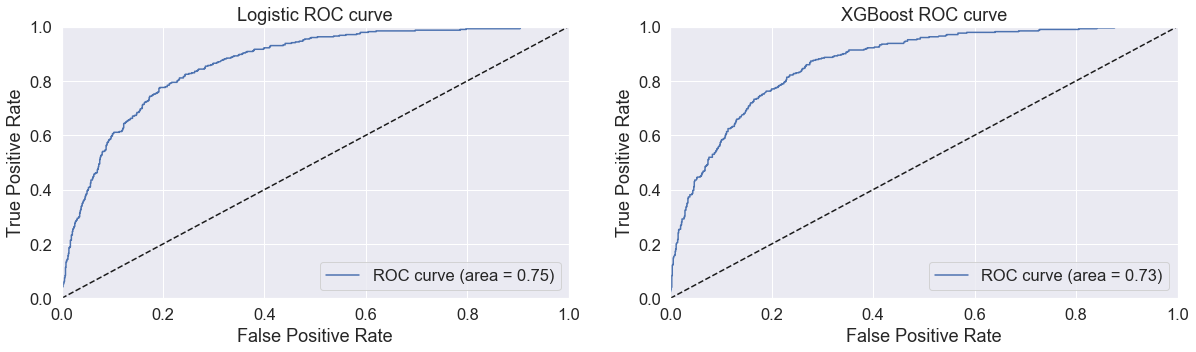

In [230]:
# plotting ROC curve(s)
sns.set(font_scale=1.5)
l_b = logistic.predict_proba(x_test)[:,1]
l_fpr, l_tpr, l_threshold = roc_curve(y_test, l_b)

x_b = xgBoost.predict_proba(x_test)[:,1]
x_fpr, x_tpr, x_threshold = roc_curve(y_test, x_b)

fig, ax = plt.subplots(1,2, figsize=(20,5))

ax[0].plot(l_fpr, l_tpr, label='ROC curve (area = %0.2f)'%logit_roc_auc)
ax[0].plot([0,1], [0,1], 'k--')
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.0])
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('Logistic ROC curve')
ax[0].legend(loc="lower right")

ax[1].plot(x_fpr, x_tpr, label='ROC curve (area = %0.2f)'%xgboost_roc_auc)
ax[1].plot([0,1], [0,1], 'k--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.0])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('XGBoost ROC curve')
ax[1].legend(loc="lower right");

In [231]:
# Let's sort XG Boost Predictors for plotting
temp_xg = pd.DataFrame(xgBoost_feature_importance)
xg_feat_plot = pd.merge(temp_xg,Columns,how="left",left_index=True,right_index=True)
xg_feat_plot.columns = ["Importance","Predictor"]
xg_feat_plot.sort_values(by='Importance',ascending=False,inplace=True)
xg_feat_plot.reset_index(drop=True,inplace=True)

In [232]:
# Let's sort Logistic Regression Predictors for plotting
temp_lr = pd.DataFrame(logistic_feature_importance)
lr_feat_plot = pd.merge(temp_lr,Columns,how="left",left_index=True,right_index=True)
lr_feat_plot.columns = ["Importance","Predictor"]
lr_feat_plot.sort_values(by='Importance',ascending=False,inplace=True)
lr_feat_plot.reset_index(drop=True,inplace=True)

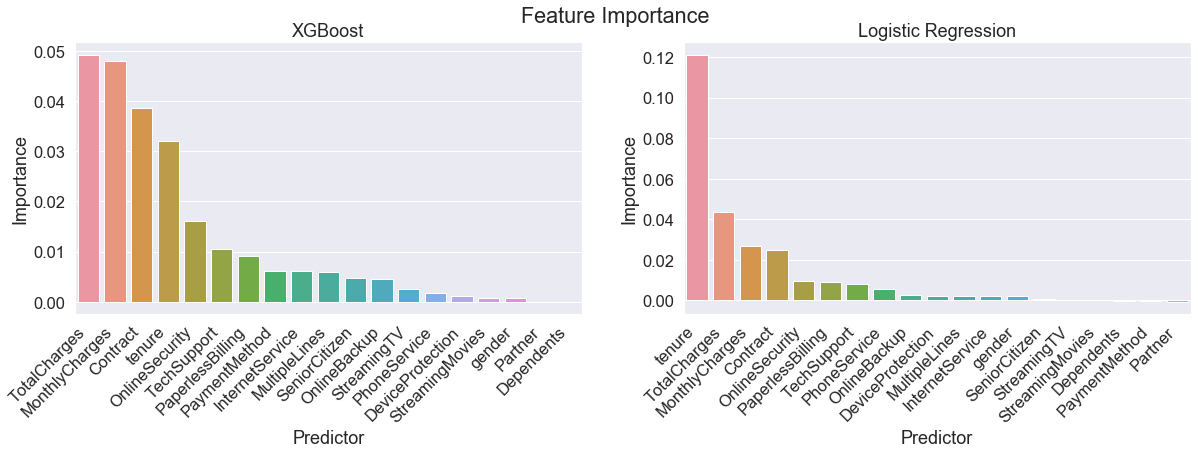

In [233]:
# plot Feature Importance of XGBoost and Logistic Regression
sns.set(font_scale=1.5)
fig, ax = plt.subplots(1,2, figsize=(20,5))
plt.suptitle('Feature Importance')
fig1 = sns.barplot(x="Predictor", y="Importance",data=xg_feat_plot, ax=ax[0])
fig2 = sns.barplot(x="Predictor", y="Importance",data=lr_feat_plot, ax=ax[1])
plt.setp(ax[0].get_xticklabels(), rotation=45, ha='right') 
plt.setp(ax[1].get_xticklabels(), rotation=45, ha='right')
ax[0].set_title("XGBoost")
ax[1].set_title("Logistic Regression");

# **Conclusion**<br>
In summary the two models that performed the "best" were logistic regression and XGBoost. Exploring predictors of churn, from the feature importance charts, we can get an idea of what attributes the business should focus on, to retain customers. It is pretty clear from the analysis, that if we can hold onto a customer (increase their tenure), they are less likely to discontinue their service (churn).
<br><br>Based on our analysis, our business recommendation is:

1.   Market/attract customers to signup for InternetService
2.   With InternetService, market attractive bundles/packages of internet services, like OnlineSecurity, TechSupport and OnlineBackup. 
3.   Monitor MonthlyCharges of customers and keep under a churn threshold, by getting customers to signup/extend for 1 and 2 year contracts, to drive down MonthlyCharges. 
4.  Since tenure plays a critical role in retaining customers, we recommend establishing a good onboarding process. Based on the model results, we could provide free or discounted tech support and online backup/security as part of this onboarding program. The ultimate goal is to retain the customer! 


Next predictive analytic steps would be to create a pipeline and optimize parameters for each of the models. For logistic regression we would want to try using recursive feature elimination (RFE) and Synthetic Minority Oversampling Technique (SMOTE). Further study is need to understand these techniques and be able to apply them correctly. As with optimizing any predictive model, there is always the danger of overfitting the model to the training data set. 